In [1]:
import pandas as pd
import os
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import pandas as pd 
import os
from termcolor import colored


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("df_preprocessed.csv", index_col=0)
test = pd.read_csv("test_preprocessed.csv", index_col=0)
df = train.copy()

In [3]:
print("Dimension :", df.shape)
df.head()

Dimension : (3694318, 22)


,id,Compartments,Weight Capacity (kg),Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,500000,10,0.842285,114.11068,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,500001,4,-0.880505,129.74972,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,500002,8,-1.422139,21.37370,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,500003,7,-1.475592,48.09209,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,500004,9,0.678764,77.32461,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [4]:
test.head()

,id,Compartments,Weight Capacity (kg),Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,300000,2.0,0.381806,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,300001,7.0,-0.637422,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,300002,9.0,-0.889009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,300003,1.0,0.067146,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300004,2.0,-1.161755,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X = df.drop(["id","Price"],axis=1)
y = df["Price"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [6]:
def enregistrement_model(pretrained_models):
    """Prend en entrée un dictionnaire sous forme {nom_modèle : modèle préentrainé}"""
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')


In [ ]:
def evaluer_modele(models):
    """L'utilisateur entre un ou une liste de modèle qui sera entrainée, on affichera un graphique du cross_val_score
    sur 5 splits et un tuple de 3 valeurs contenant les prédictions, le datafram"""    
    #On verifie si l'utilisateur à rentrer une liste de modèle ou un modèle unique
    if type(models) != list: #on transforme en liste si un seul modèle
        models = [models]     
    #Création des dictionnaires qui contiendrons les prédictions et les différentes metriques
    metrics = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Exe_time':[]}
    predictions = {}    
    #dictionnaire pour stocker les modèles entraînés
    trained_models = {}      
    
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(estimator=model, X=X_train.values, y=y_train,  scoring="neg_mean_squared_error")#RMSE
        #rappel du score : negative MSE, plus la valeur retournée est élevée (+ proche de 0) et mieux c'est
        #par ex -1500 < -5, -5 est plus élevé, donc meilleur.
        
        #Debut entrainement
        start_time = time.time()
        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train)
        #Fin entrainement :
        end_time = time.time()
        # durée totale de l'entrainement 
        training_time = round(end_time - start_time,2)
        # Durée en minute :
        training_time_min = round(training_time/60,2)        
        
        #prédictions sur X_test
        y_pred = model.predict(X_test)
        # Calcul des métriques sur X_test
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Ajoute au dictionnaire
        metrics['MSE'].append(mse),
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)
        metrics['R2'].append(r2)
        metrics["Exe_time"].append(training_time_min)        
        #Ajout des prédictions dans le dictionnaire 
        predictions[model_name] = y_pred
        #Stockage du modèle entrainé
        trained_models[model_name] = model  

        # lineplot pour le cross val score :
        plt.figure(figsize=(8,3))
        sns.lineplot(x = [i+1 for i in range(len(scores))], y = scores)
        plt.xlabel('n')
        plt.ylabel('neg_MSE')
        plt.title(f"{model_name}")
        plt.show()
        #CV moyen sur 5 splits :
        print("Score moyen sur 5 splits : ", round(scores.mean(),2))
        print("-"*30)       
    # Convertir metrics en DataFrame avec les noms des modèles comme index
    metrics_df = pd.DataFrame(metrics, index=[model.__class__.__name__ for model in models])
    
    return trained_models, predictions, metrics_df

In [8]:
# Liste des modèles à tester
models = [
    DummyRegressor(strategy="mean"),
    LinearRegression(),
     Ridge(),
    ElasticNet(),
#     KNeighborsRegressor(),
    HuberRegressor(),
# RandomForestRegressor(random_state=42)
]


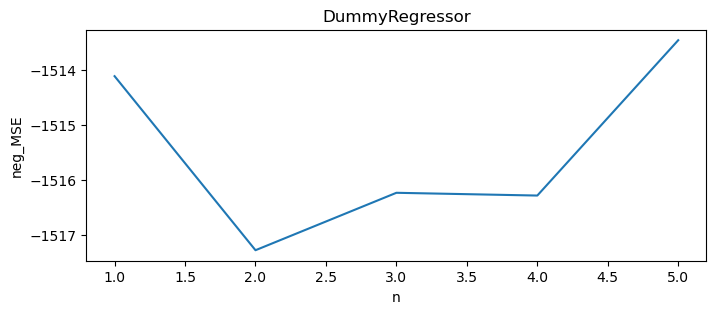

Score moyen sur 5 splits :  -1515.47
------------------------------


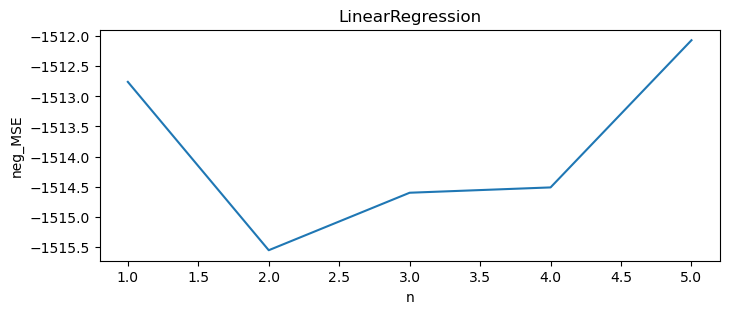

Score moyen sur 5 splits :  -1513.9
------------------------------


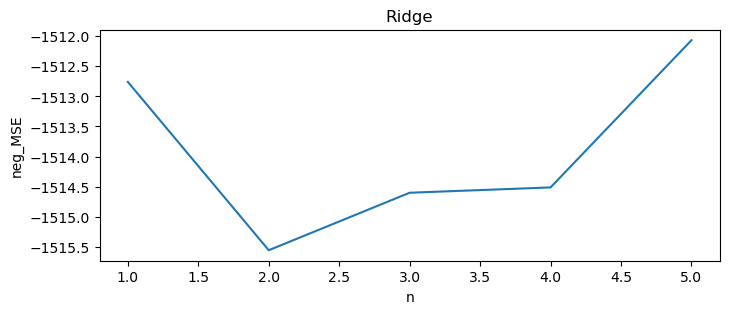

Score moyen sur 5 splits :  -1513.9
------------------------------


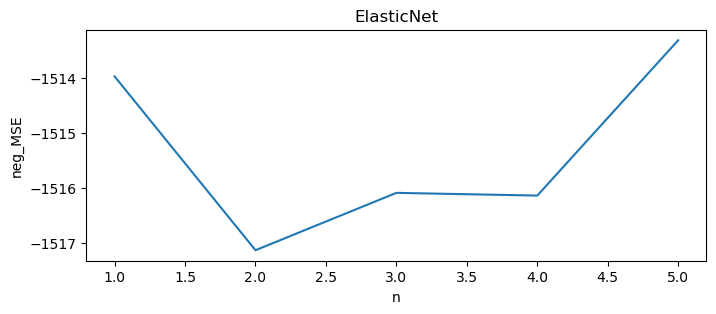

Score moyen sur 5 splits :  -1515.32
------------------------------


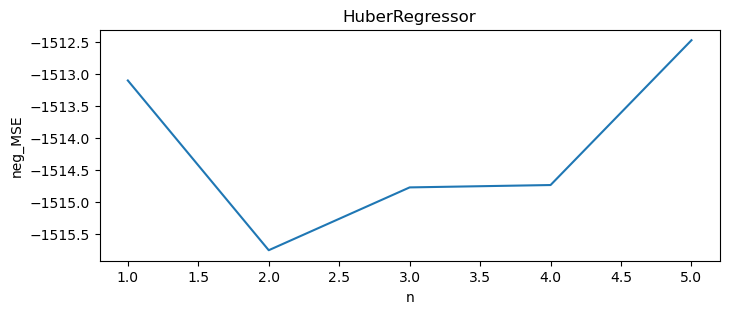

Score moyen sur 5 splits :  -1514.16
------------------------------


In [9]:
model_trained, prediction, metric_df = evaluer_modele(models)

In [10]:
metric_df.drop("R2",axis=1, inplace=True)

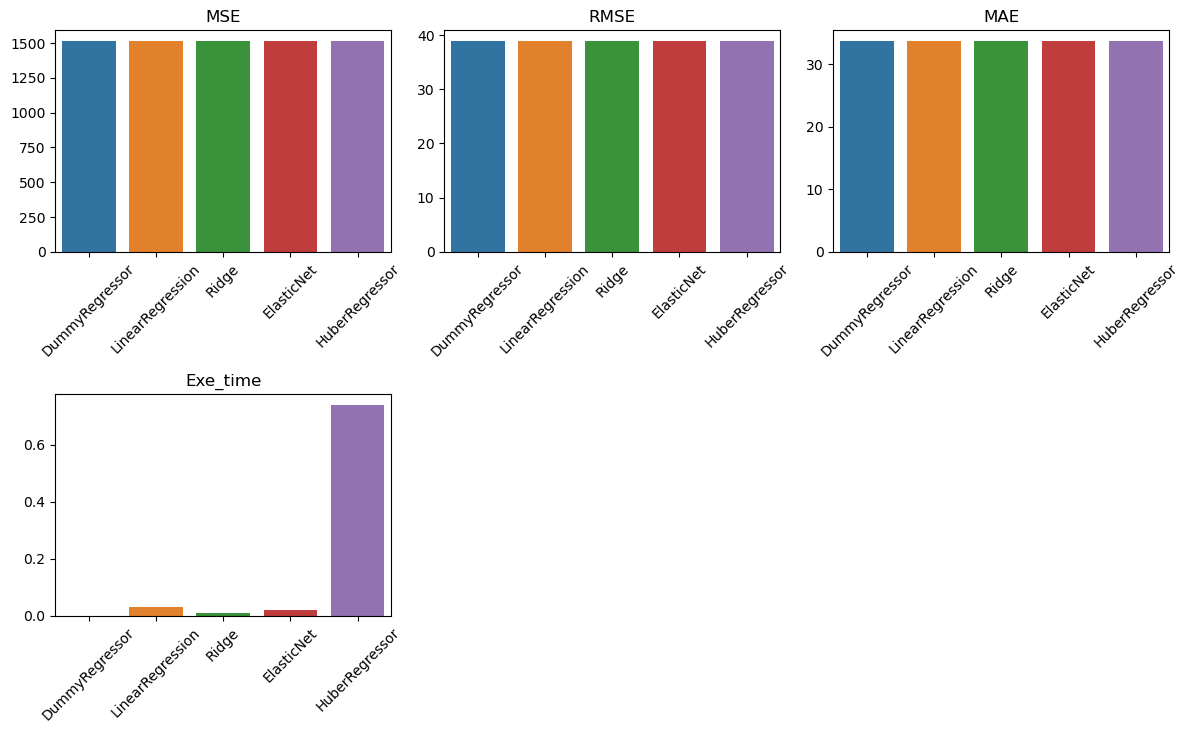

In [11]:
plt.figure(figsize=(12,10))
for i,col in enumerate(metric_df,1):
    plt.subplot(3,3,i)
    plt.title(f"{col}")
    ax = sns.barplot(x = metric_df.index, y = col , data = metric_df)
    lab = ax.get_xticklabels()
    ax.set_xticklabels(labels =lab,rotation=45)
    ax.set_ylabel(None)
    plt.tight_layout()
plt.show()

In [12]:
enregistrement_model(model_trained)

DummyRegressor enregistré sous DummyRegressor.pkl
LinearRegression enregistré sous LinearRegression.pkl
Ridge enregistré sous Ridge.pkl
ElasticNet enregistré sous ElasticNet.pkl
HuberRegressor enregistré sous HuberRegressor.pkl


In [ ]:
def read_data(path):
    with open(path, 'rb') as file:
        loaded_file = pickle.load(file)
        name = path.split('/')[-1]
    print(f"Données chargées depuis {colored(path,'blue')} : {colored(name,'green',attrs=['bold'])}")
    return loaded_file

In [ ]:
ElasticNet = read_data(os.getcwd()+"\\ElasticNet.pkl")
Linear = read_data(os.getcwd()+"\\LinearRegression.pkl")

In [ ]:
ypred = ElasticNet.predict(X_test)
# Distribution des résidus pour ElasticNet
residuals = y_test - ypred
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, color='blue')
plt.title("Distribution des résidus")
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
plt.scatter(y_test, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="red", linestyle="--")  # Ligne indiquant zéro erreur
plt.title("Graphique des résidus (Valeurs réelles vs erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Erreurs (y_test - y_pred)")
plt.show()

In [ ]:
ypred = Linear.predict(X_test)
# Distribution des résidus pour LinearRegression
residuals = y_test - ypred
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, color='blue')
plt.title("Distribution des résidus")
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
plt.scatter(y_test, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="red", linestyle="--")  # Ligne indiquant zéro erreur
plt.title("Graphique des résidus (Valeurs réelles vs erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Erreurs (y_test - y_pred)")
plt.show()

In [ ]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    prediction = model.predict(X)
    
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(prediction, columns = ["Premium Amount"], index = id_data)
    return prediction_df

In [ ]:
new_prediction(ElasticNet, test).to_csv("prediction_ElasticNet.csv")
new_prediction(Linear, test).to_csv("prediction_LinearRegression.csv")